<table>
    <tr>
        <td><img src="https://raw.githubusercontent.com/Fabian830348/Bases_Datos/refs/heads/master/Logo_EICT_horizontal_ESPANOL%20(1).png" width="300"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="font-size:200%;color:blue;text-align:center">    <FONT COLOR="blue">  Entregable 3   </p> PLN+ML</FONT>         </h1></td>         
        <td>
            <tp><p style="font-size:99%;text-align:center">Aprendizaje Automático de Máquina </p></tp>
            <tp><p style="font-size:115%;text-align:center">Maestría MACC 2025-2</p></tp>
            <tp><p style="font-size:115%;text-align:center">Sifred Humnerto
                                                            David Rodriguez
                                                            Juan Camilo Sanmiguel</p></tp>
        </td>
    </tr>
</table>

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import csv
import time
import random

In [ ]:
BASE_URL = "https://es.trustpilot.com/review/amazon.es"
MAX_PAGES = 50  # lo que pide el profesor

# ---------------- Configuración del navegador ----------------
chrome_options = Options()

# User-Agent de Chrome "humano"
chrome_options.add_argument(
    "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
    "AppleWebKit/537.36 (KHTML, like Gecko) "
    "Chrome/120.0.0.0 Safari/537.36"
)

# Ocultar en lo posible que es Selenium
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option("useAutomationExtension", False)
chrome_options.add_argument("--disable-blink-features=AutomationControlled")

driver = webdriver.Chrome(options=chrome_options)

# Quitar navigator.webdriver = true
driver.execute_cdp_cmd(
    "Page.addScriptToEvaluateOnNewDocument",
    {
        "source": """
            Object.defineProperty(navigator, 'webdriver', {
                get: () => undefined
            })
        """
    },
)

wait = WebDriverWait(driver, 15)
resultados = []

# ---------------- Medir tiempo total ----------------
t0 = time.time()

try:
    # -------- PRIMERA VISITA: aceptar cookies si salen --------
    driver.get(BASE_URL)
    time.sleep(3)

    try:
        boton_cookies = driver.find_element(
            By.XPATH,
            '//button[contains(text(), "Aceptar") or '
            'contains(text(), "Acepto") or '
            'contains(text(), "Consentir")]'
        )
        boton_cookies.click()
        time.sleep(2)
    except Exception:
        # Si no aparece banner, continuamos
        pass

    # -------- LOOP SOBRE LAS PÁGINAS --------
    for page in range(1, MAX_PAGES + 1):
        url = f"{BASE_URL}?page={page}"
        print(f"\nScrapeando página {page}: {url}")
        driver.get(url)

        # Pausa aleatoria para no parecer bot
        time.sleep(random.uniform(1.5, 3.0))

        # Si nos redirigen fuera de la página de reseñas, paramos
        if "review/amazon.es" not in driver.current_url:
            print(f"Redirigido a {driver.current_url}. Probable login / límite. Paro aquí.")
            break

        # Hacemos scroll para simular usuario y asegurar carga
        try:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(random.uniform(1.0, 2.0))
        except Exception:
            pass

        # Intentar localizar artículos de reseña
        tarjetas = driver.find_elements(By.XPATH, "//main//article")
        if not tarjetas:
            print(f"En la página {page} ya no hay reseñas visibles. Paro aquí.")
            break

        print(f"  Encontradas {len(tarjetas)} reseñas")

        for card in tarjetas:
            # ---------- ESTRELLAS ----------
            estrellas = None
            try:
                rating_div = card.find_element(
                    By.XPATH,
                    './/div[@data-service-review-rating]'
                )
                estrellas_str = rating_div.get_attribute("data-service-review-rating")
                if estrellas_str is not None:
                    estrellas = int(estrellas_str)
            except Exception:
                pass

            # ---------- FECHA DE EXPERIENCIA ----------
            fecha_iso = None        # atributo datetime (ISO)
            fecha_texto = None      # texto visible (ej. "Hace 3 horas")
            try:
                time_tags = card.find_elements(By.TAG_NAME, "time")
                for t_tag in time_tags:
                    iso = t_tag.get_attribute("datetime")
                    if iso:
                        fecha_iso = iso
                        fecha_texto = t_tag.text.strip()
                        break
            except Exception:
                pass

            # ---------- TEXTO DEL COMENTARIO ----------
            comentario = None
            try:
                p = card.find_element(
                    By.XPATH,
                    './/p[@data-service-review-text-typography="true"]'
                )
                comentario = p.get_attribute("textContent") or ""
                comentario = comentario.replace("Ver más", "").strip()
            except Exception:
                pass

            # Si no tenemos nada útil, lo saltamos
            if estrellas is None and comentario is None:
                continue

            resultados.append({
                "page": page,
                "stars": estrellas,
                "date_iso": fecha_iso,
                "date_text": fecha_texto,
                "comment": comentario
            })

        # Pausa extra antes de pasar a la siguiente página
        time.sleep(random.uniform(1.0, 2.0))

finally:
    driver.quit()

t1 = time.time()
elapsed = t1 - t0

# ---------------- Guardar en CSV ----------------
nombre_csv = "trustpilot_amazon_50paginas.csv"
with open(nombre_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=["page", "stars", "date_iso", "date_text", "comment"]
    )
    writer.writeheader()
    writer.writerows(resultados)

print(f"\nListo. Guardadas {len(resultados)} reseñas en {nombre_csv}")
print(f"Tiempo total: {elapsed:.2f} segundos")
print(f"Páginas que realmente se pudieron scrapear: {len(set(r['page'] for r in resultados))}")



Scrapeando página 1: https://es.trustpilot.com/review/amazon.es?page=1
  Encontradas 68 reseñas

Scrapeando página 2: https://es.trustpilot.com/review/amazon.es?page=2
  Encontradas 68 reseñas

Scrapeando página 3: https://es.trustpilot.com/review/amazon.es?page=3
  Encontradas 68 reseñas

Scrapeando página 4: https://es.trustpilot.com/review/amazon.es?page=4
  Encontradas 68 reseñas

Scrapeando página 5: https://es.trustpilot.com/review/amazon.es?page=5
  Encontradas 68 reseñas

Scrapeando página 6: https://es.trustpilot.com/review/amazon.es?page=6
  Encontradas 68 reseñas

Scrapeando página 7: https://es.trustpilot.com/review/amazon.es?page=7
  Encontradas 68 reseñas

Scrapeando página 8: https://es.trustpilot.com/review/amazon.es?page=8
  Encontradas 68 reseñas

Scrapeando página 9: https://es.trustpilot.com/review/amazon.es?page=9
  Encontradas 68 reseñas

Scrapeando página 10: https://es.trustpilot.com/review/amazon.es?page=10
  Encontradas 68 reseñas

Scrapeando página 11: https

Aunque el código fue desarrollado para extraer información de hasta 50 páginas de reseñas, el proceso de scraping se interrumpe alrededor de la página 10, debido a que el sitio web solicita iniciar sesión a partir de ese punto. Esta restricción forma parte de los mecanismos de seguridad implementados por Trustpilot para limitar el acceso automatizado a sus datos y evitar el uso de bots con fines no autorizados. Por lo tanto, aun cuando el programa esté configurado para continuar el recorrido, el acceso a más páginas no es permitido sin autenticación, lo que evidencia una limitación técnica asociada al control de información del portal.

## 2 ) Creación DF

In [13]:
import pandas as pd

# 1. Cargar el CSV que generaste con Selenium
ruta_csv = "trustpilot_amazon_50paginas.csv"
df_raw = pd.read_csv(ruta_csv)

# 2. Quedarnos solo con las tres columnas que pide el enunciado
#    - comentario  -> texto del comentario
#    - calificación -> número de estrellas (1 a 5)
#    - fecha        -> fecha de experiencia (uso date_iso, que es ISO)
df = df_raw[['comment', 'stars', 'date_iso']].copy()

# 3. Renombrar las columnas como pide el profe
df = df.rename(columns={
    'comment': 'comentario',
    'stars': 'calificacion',
    'date_iso': 'fecha'
})

# 4. (Opcional) convertir la fecha a tipo datetime
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# 5. Ver las primeras filas para comprobar
print(df.head())
print(df.info())


                                          comentario  calificacion  \
0  Mi experiencia ha sido muy negativa. Realicé u...             1   
1  Te envían artículos usados que tú compras como...             1   
2  El servicio de atención al "cliente" es patéti...             1   
3  Siempre me fue muy bien. El servicio de entreg...             5   
4  No se puede trabajar con empresas de logistica...             1   

                      fecha  
0 2025-11-21 21:37:49+00:00  
1 2025-11-21 09:00:26+00:00  
2 2025-11-19 18:45:03+00:00  
3 2025-11-19 11:43:36+00:00  
4 2025-11-19 11:41:51+00:00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   comentario    199 non-null    object             
 1   calificacion  200 non-null    int64              
 2   fecha         200 non-null    datetime64[ns, UTC]
dtypes: datetime64[n

In [14]:
df.head()

,comentario,calificacion,fecha
0,Mi experiencia ha sido muy negativa. Realicé u...,1,2025-11-21 21:37:49+00:00
1,Te envían artículos usados que tú compras como...,1,2025-11-21 09:00:26+00:00
2,"El servicio de atención al ""cliente"" es patéti...",1,2025-11-19 18:45:03+00:00
3,Siempre me fue muy bien. El servicio de entreg...,5,2025-11-19 11:43:36+00:00
4,No se puede trabajar con empresas de logistica...,1,2025-11-19 11:41:51+00:00


Asi ya quedo organizado el Dataframe para un mejor analisis 

## 3) Limpieza de texto 

In [15]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Camilo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [16]:
import pandas as pd
import re
from nltk.corpus import stopwords

# Usar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    if not isinstance(texto, str):
        return ""
    
    # 1) pasar a minúsculas
    texto = texto.lower()
    
    # 2) eliminar caracteres especiales y signos de puntuación
    texto = re.sub(r"[^a-záéíóúñü\s]", "", texto)
    
    # 3) eliminar números
    texto = re.sub(r"\d+", "", texto)
    
    # 4) eliminar espacios extras
    texto = re.sub(r"\s+", " ", texto).strip()
    
    # 5) eliminar stopwords
    palabras = texto.split()
    palabras_filtradas = [p for p in palabras if p not in stopwords_es]
    
    # 6) volver a unir
    return " ".join(palabras_filtradas)

# Aplicar la función como nueva columna
df['comentario_limpio'] = df['comentario'].apply(limpiar_texto)

# Ver resultados
print(df[['comentario', 'comentario_limpio']].head())


                                          comentario  \
0  Mi experiencia ha sido muy negativa. Realicé u...   
1  Te envían artículos usados que tú compras como...   
2  El servicio de atención al "cliente" es patéti...   
3  Siempre me fue muy bien. El servicio de entreg...   
4  No se puede trabajar con empresas de logistica...   

                                   comentario_limpio  
0  experiencia sido negativa realicé pedido fecha...  
1  envían artículos usados compras nuevos luego d...  
2  servicio atención cliente patético llevo minin...  
3  siempre bien servicio entrega si hacer devoluc...  
4  puede trabajar empresas logistica paack miente...  


In [17]:
df.head(10)

,comentario,calificacion,fecha,comentario_limpio
0,Mi experiencia ha sido muy negativa. Realicé u...,1,2025-11-21 21:37:49+00:00,experiencia sido negativa realicé pedido fecha...
1,Te envían artículos usados que tú compras como...,1,2025-11-21 09:00:26+00:00,envían artículos usados compras nuevos luego d...
2,"El servicio de atención al ""cliente"" es patéti...",1,2025-11-19 18:45:03+00:00,servicio atención cliente patético llevo minin...
3,Siempre me fue muy bien. El servicio de entreg...,5,2025-11-19 11:43:36+00:00,siempre bien servicio entrega si hacer devoluc...
4,No se puede trabajar con empresas de logistica...,1,2025-11-19 11:41:51+00:00,puede trabajar empresas logistica paack miente...
5,Hace una semana exactamente que pedimos una tv...,1,2025-11-18 21:17:43+00:00,hace semana exactamente pedimos tv amazon sien...
6,"He tenido algunos problemas con Amazon, siempr...",1,2025-11-18 20:55:28+00:00,problemas amazon siempre culpa protocolos buen...
7,Pésima actitud y pésimo servicio Postventa. Hi...,1,2025-11-18 21:37:29+00:00,pésima actitud pésimo servicio postventa hice ...
8,6 meses para enviar 2 pedidos realizados en MA...,1,2025-11-18 19:10:04+00:00,meses enviar pedidos realizados mayo razón apa...
9,Voy a lanzar esta bomba a toda España y está c...,1,2025-11-17 03:38:47+00:00,voy lanzar bomba toda españa confirmado depart...


En esta etapa se realizó la limpieza del texto con el objetivo de preparar los comentarios para el análisis posterior. El proceso consistió en estandarizar el contenido a minúsculas, eliminar signos de puntuación, números y palabras irrelevantes conocidas como stopwords. Este tipo de depuración permite reducir ruido en los datos y conservar únicamente las palabras más representativas del comentario, lo cual facilita el análisis de frecuencia de términos y la construcción de una nube de palabras. Gracias a esta limpieza, es posible interpretar de manera más clara el lenguaje utilizado por los usuarios y destacar los aspectos que más se repiten en las reseñas.

## 4) tabla de frecuencia

In [18]:
# Punto 4: Tabla de frecuencia de la variable calificación
tabla_frecuencia = df['calificacion'].value_counts().sort_index()

print("Tabla de frecuencia de calificaciones:")
print(tabla_frecuencia)


Tabla de frecuencia de calificaciones:
calificacion
1    166
2      6
3      3
4      7
5     18
Name: count, dtype: int64


In [19]:
tabla_frecuencia_pct = (df['calificacion'].value_counts(normalize=True) * 100).sort_index()

print("\nFrecuencia porcentual (%):")
print(tabla_frecuencia_pct)



Frecuencia porcentual (%):
calificacion
1    83.0
2     3.0
3     1.5
4     3.5
5     9.0
Name: proportion, dtype: float64


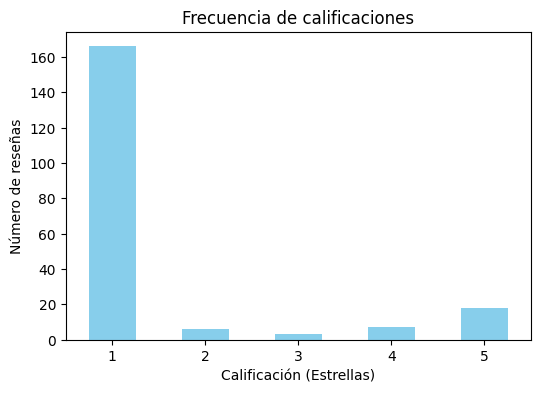

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
tabla_frecuencia.plot(kind='bar', color='skyblue')
plt.title("Frecuencia de calificaciones")
plt.xlabel("Calificación (Estrellas)")
plt.ylabel("Número de reseñas")
plt.xticks(rotation=0)
plt.show()


La tabla de frecuencia muestra la distribución de las calificaciones otorgadas por los usuarios. Esto permite identificar si la mayoría de reseñas son positivas o negativas y qué tan polarizada es la experiencia de los clientes. A partir de esta información se pueden observar tendencias generales de satisfacción.

## 5) Nube de Palabras

In [23]:
text = " ".join(df['comentario_limpio'].dropna().tolist())
print("Longitud del texto:", len(text))


Longitud del texto: 65438


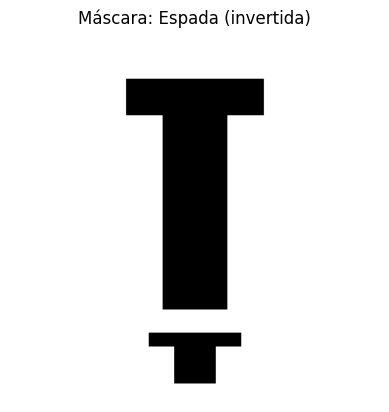

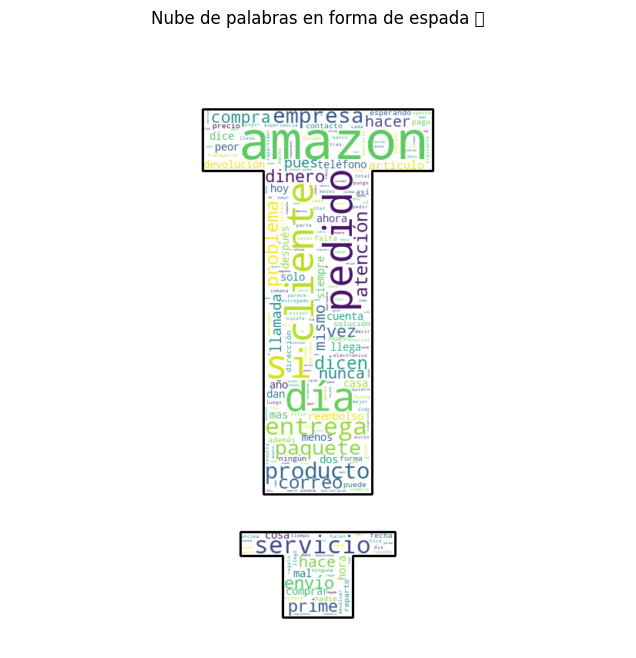

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# ======================
# Crear máscara de espada por código
# ======================

h, w = 800, 800
mask = np.zeros((h, w), dtype=np.uint8)

# ----- Hoja de la espada -----
mask[180:600, 330:470] = 255

for row in range(80):
    mask[180-row:180, 330-row:470+row] = 255

# ----- Empuñadura -----
mask[650:680, 300:500] = 255
mask[680:760, 355:445] = 255

# 🔁 Invertir máscara para que las palabras vayan DENTRO de la espada
mask = 255 - mask

# Mostrar la máscara
plt.imshow(mask, cmap="gray")
plt.title("Máscara: Espada (invertida)")
plt.axis("off")
plt.show()

# ======================
# Crear NUBE DE PALABRAS
# ======================

text = " ".join(df['comentario_limpio'].dropna().tolist())

wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    mask=mask,
    stopwords=set(STOPWORDS),
    collocations=False,
    max_words=500,
    contour_width=2,
    contour_color="black"
).generate(text)

plt.figure(figsize=(8, 8))
plt.imshow(wc, interpolation="bilinear")
plt.title("Nube de palabras en forma de espada 🗡️")
plt.axis("off")
plt.show()


## 6) Conclusiones

A partir de la nube de palabras generada y de la tabla de frecuencia de calificaciones, se observan tendencias claras sobre la percepción de los usuarios frente a Amazon España. En la nube destacan términos como pedido, entrega, servicio, cliente, producto, correo y empresa, lo cual indica que la mayoría de los comentarios giran alrededor del proceso de compra y envío, más que sobre la calidad del producto en sí.

Asimismo, palabras como problema, retraso, devolución, nunca, peor evidencian que la experiencia del usuario tiende a ser negativa, especialmente cuando ocurren demoras en la entrega o complicaciones con el soporte al cliente. Estos hallazgos se complementan con la tabla de frecuencias de calificación, donde se aprecia una alta proporción de evaluaciones bajas (1 o 2 estrellas).

En general, tanto la nube de palabras como la distribución de calificaciones sugieren que los clientes presentan un nivel significativo de insatisfacción asociado principalmente al tiempo de entrega y a la efectividad del servicio de atención al cliente, los cuales representan los puntos críticos en la experiencia de compra evaluada.